In [270]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [271]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [272]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, select ,func

In [273]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [274]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [275]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [276]:
# Save references to each table
m = Base.classes.measurement

s = Base.classes.station

In [277]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [278]:
# Find the most recent date in the data set.
session.execute("SELECT * FROM measurement LIMIT 10").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [279]:
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
#columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


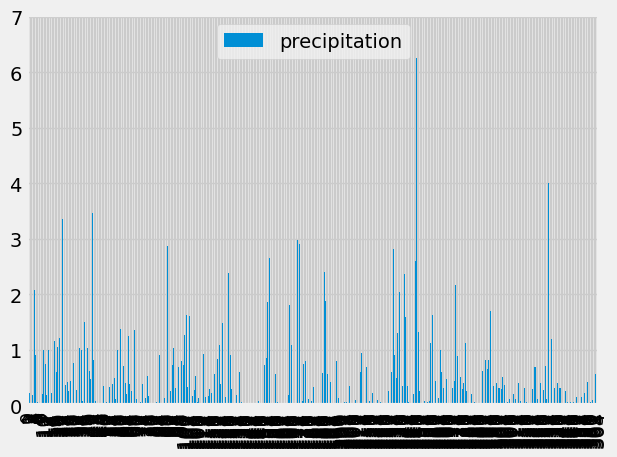

In [280]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
sel = [m.date,
       func.max(m.prcp)]

last_date = session.query(*sel).\
    order_by(m.date.desc()).first()


# Calculate the date one year from the last date in data set.
date = dt.datetime(2017,8,23)-dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
one_year_data= session.query(*sel).\
    filter(func.strftime(m.date)>=date).\
        group_by(m.date).all()

one_year_data

# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_df = pd.DataFrame(one_year_data, columns=["date","precipitation"])

# Sort the dataframe by date
one_year_sorted_df = one_year_df.sort_values(by=["date"])
one_year_sorted_df

# Use Pandas Plotting with Matplotlib to plot the data
one_year_sorted_df.set_index("date")
one_year_sorted_df.plot.bar()
plt.tight_layout()
plt.show()


In [281]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_sorted_df[["date","precipitation"]].describe()

,precipitation
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


# Exploratory Station Analysis

In [282]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(m.station)).all()

[(19550,)]

In [295]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count = session.query(m.station, func.count("*")).\
    group_by(m.station).order_by(func.count("*").desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [309]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest = session.query( m.date, func.min(m.tobs)).\
    filter(m.station == "USC00519281").first()


highest = session.query( m.date, func.max(m.tobs)).\
    filter(m.station == "USC00519281").first()

average = session.query(func.avg(m.tobs)).\
    filter(m.station == "USC00519281").all()

print(f"Station: USC00519281\nLowest temperature:{lowest}\nHighest temperature:{highest}\nAverage temperature:{average}")



Station: USC00519281
Lowest temperature:('2013-01-16', 54.0)
Highest temperature:('2015-09-10', 85.0)
Average temperature:[(71.66378066378067,)]


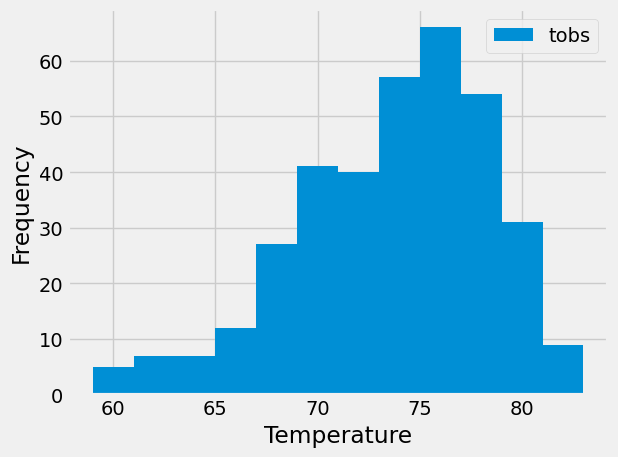

In [332]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date2 = dt.datetime(2017,8,18)-dt.timedelta(days=365)

year_temperature = session.query(m.tobs).\
    filter(m.station == "USC00519281").\
        filter(m.date > date2).\
            all()

#put into a dataframe
year_temperature_df = pd.DataFrame(year_temperature, columns=["tobs"])


year_temperature_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()


# Close session

In [333]:
# Close Session
session.close()